# Fine-Tuning Pretrained Image Classification Model with AWS SageMaker and TensorFlow 

In recent years, deep learning has revolutionized the field of computer vision with its ability to accurately classify images. One of the most popular techniques for image classification is using convolutional neural networks (CNNs), which have shown excellent results in comparison with others approaches such as full connected neural networks. However, training these models from scratch can be computationally intensive and time-consuming. To overcome this, another approach called transfer learning has been used and has become increasingly popular.

This project, uses Amazon Web Services (AWS) SageMaker and Tensorflow to fine-tune a pretrained model for binary image classification. The dataset used in this project can be found at https://www.kaggle.com/datasets/deepcontractor/is-that-santa-image-classification. In addition, SageMaker Debugger was used to measure performance of training job, system resource usage, and for framework metrics analysis.

Move kaggle.json to project root

In [108]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Install requirements

In [6]:
# install tensorflow, smdebug
#!pip install --upgrade pip
#!pip install --upgrade sagemaker
!pip install -q -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [7]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython
from PIL import Image
import json
import random
from sagemaker.tensorflow import TensorFlow
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.debugger import DebuggerHookConfig, Rule, rule_configs, ProfilerConfig, ProfilerRule,  FrameworkProfile,  CollectionConfig
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from smdebug.profiler.analysis.notebook_utils.metrics_histogram import MetricsHistogram

### Donwload dataset from kaggle
Dataset structure:

Santa: Images of Santa Claus

not-a-santa: Images of people, actors, animals, etc. 


For details about this dataset see: [IS THAT SANTA? (Image Classification)](https://www.kaggle.com/datasets/deepcontractor/is-that-santa-image-classification)

In [65]:
# Donwload dataset from kaggle
!kaggle datasets download -d deepcontractor/is-that-santa-image-classification

 99%|████████████████████████████████████████▋| 202M/203M [00:01<00:00, 157MB/s]
100%|████████████████████████████████████████| 203M/203M [00:03<00:00, 66.2MB/s]


In [66]:
# Unzip dataset
!unzip is-that-santa-image-classification.zip

upload: ./is-that-santa-image-classification.zip to s3://sagemaker-us-east-1-890701353618/datasets/is-that-santa-image-classification.zip


In [ ]:
# Convert images format from jpg to jpeg
!./convert_jpg_to_jpeg.sh -d -r is_that_santa/

In [99]:
# Copy dataset to s3
!aws s3 cp is_that_santa s3://sagemaker-us-east-1-890701353618/datasets/ --recursive > /dev/null

In [8]:
# Create a new session, role and get region
session = sagemaker.Session()
role = get_execution_role()
region = session.boto_region_name

## Hyperparameter Tuning

In [15]:
# Define a range of hyperparameters for the model training
hyperparameters_range = {
    "learning-rate": ContinuousParameter(1e-4, 1e-3),
    "epochs": IntegerParameter(4,10),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "beta_1": ContinuousParameter(0.1, 0.9),
    "beta_2": ContinuousParameter(0.1, 0.999)
}

In [16]:
# Create a TensorFlow estimator for training the model
estimator = TensorFlow(
    # Specify the entry point script for the training job
    entry_point= "hpo.py",
    # Assign the AWS IAM role for the training job
    role = role,
    # Set the number of instances for the training job to 1
    instance_count=1,
    # Specify the instance type for the training job
    instance_type="ml.m5.large",
    # Set the source directory for the training scripts
    source_dir="scripts",
    # Set the version of TensorFlow to use
    framework_version="2.10.0",
    # Set the version of Python to use
    py_version="py39",
    # Set S3 location where the checkpoint data and models can be exported to during training to False
    model_dir = "/opt/ml/model",
    # Specify the hyperparameters
    #hyperparameters={
    #    "batch-size": 256,
    #    "epochs": 10,
    #}
)

# Define a objective metric to tune. Note: the entry point script must return the same metric specified here
objective_metric_name = "average test loss"

# Define the objective (Minimize or Maximize)
objective_type = "Minimize"

# Define the metric definitions such as name and a regular expression needed to 
# extract the metric from the CloudWatch logs of the training job
metric_definitions = [{ "Name": "average test loss", "Regex": "Test Loss: ([0-9\\.]+)"}]

# Define a HyperparameterTuner 
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameters_range,
    metric_definitions,
    max_jobs=2, # Number of training jobs to run
    max_parallel_jobs=2, # Number of training jobs to run in parallel
    objective_type=objective_type
)

In [17]:
# Location of the training data on s3 
training_loc = 's3://sagemaker-us-east-1-890701353618/datasets/train'

# Location of the test data on s3 
test_loc = 's3://sagemaker-us-east-1-890701353618/datasets/test'

# Define the input channels for the training and testing data
channels = {"training": training_loc, "testing": test_loc}

# Fit the tuner to the input data channels
tuner.fit(inputs=channels) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.........................................................................................!


In [18]:
# Get the best training job 
tuner.best_training_job()

'tensorflow-training-230213-1705-002-0372387f'

In [19]:
# Get the best estimator
best_estimator = tuner.best_estimator()
best_estimator


2023-02-13 17:12:14 Starting - Preparing the instances for training
2023-02-13 17:12:14 Downloading - Downloading input data
2023-02-13 17:12:14 Training - Training image download completed. Training in progress.
2023-02-13 17:12:14 Uploading - Uploading generated training model
2023-02-13 17:12:14 Completed - Resource retained for reuse


In [20]:
#Get the hyperparameters of the best trained model
hypers = best_estimator.hyperparameters()
print(json.dumps(hypers, indent=4))

{
    "_tuning_objective_metric": "\"average test loss\"",
    "batch-size": "\"32\"",
    "beta_1": "0.7789475014825643",
    "beta_2": "0.516957219894723",
    "epochs": "6",
    "learning-rate": "0.0007225450522217033",
    "sagemaker_container_log_level": "20",
    "sagemaker_estimator_class_name": "\"TensorFlow\"",
    "sagemaker_estimator_module": "\"sagemaker.tensorflow.estimator\"",
    "sagemaker_job_name": "\"tensorflow-training-2023-02-13-17-05-18-054\"",
    "sagemaker_program": "\"hpo.py\"",
    "sagemaker_region": "\"us-east-1\"",
    "sagemaker_submit_directory": "\"s3://sagemaker-us-east-1-890701353618/tensorflow-training-2023-02-13-17-05-18-054/source/sourcedir.tar.gz\"",
    "model_dir": "\"/opt/ml/model\""
}


## Model Profiling and Debugging

In [21]:
# List of rules for the Amazon SageMaker Debugger
rules = [
    # Check for low GPU utilization
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    # Create a profiler report
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    # Check for CPU bottlenecks
    ProfilerRule.sagemaker(rule_configs.CPUBottleneck()),
    # Check for load balancing issues
    ProfilerRule.sagemaker(rule_configs.LoadBalancing()),
    # Check if the loss is not decreasing
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    # Check for vanishing gradients
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    # Check for overfitting
    Rule.sagemaker(rule_configs.overfit()),
    # Check for overtraining
    Rule.sagemaker(rule_configs.overtraining()),
    # Check for poor weight initialization
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    # Check for class imbalance
    Rule.sagemaker(rule_configs.class_imbalance())
]


# Configuration for the Amazon SageMaker Debugger hook
debugger_config = DebuggerHookConfig(
    hook_parameters={
        # Specify the exact step numbers to save tensors in training
        "train.save_interval": "100", 
        # Specify the exact step numbers to save tensors in test
        "eval.save_interval": "10"
    }
)   

# Configuration for the Amazon SageMaker Profiler
profiler_config = ProfilerConfig(
    # Monitor the system every 500 milliseconds
    system_monitor_interval_millis=500, 
    # Profile the framework every 10 steps
    framework_profile_params=FrameworkProfile(num_steps=10)
)

In [25]:
# Get hyperparameter from best model
batch_size = hypers["batch-size"] # return a string
learning_rate = hypers["learning-rate"] 
beta_1 = hypers["beta_1"]
beta_2 = hypers["beta_2"]
model_dir = hypers["model_dir"]
epochs = hypers["epochs"]

print("Hyperparameters")
print(f"\nBatch size: {batch_size}")
print(f"\nLearning rate: {learning_rate}") 
print(f"\nModel dir: {model_dir}")
print(f"\nBeta_1: {beta_1}")
print(f"\nBeta_2: {beta_2}")
print(f"\nEpochs: {epochs}")


# Define model hyperparameters
hyperparameters = {
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "beta_1": beta_1,
    "beta_2": beta_2,
    "epochs": epochs}

# Create a TensorFlow estimator for training the model
estimator = TensorFlow(
    # Specify the entry point script for the training job
    entry_point= "train_model.py",
    # Assign the AWS IAM role for the training job
    role = role,
    # Set the number of instances for the training job to 1
    instance_count=1,
    # Specify the instance type for the training job
    instance_type="ml.m5.large",
    # Set the source directory for the training scripts
    source_dir="scripts",
    # Set the version of TensorFlow to use
    framework_version="2.9",
    # Set the version of Python to use
    py_version="py39",
    # Set hyperparameters for training job
    hyperparameters=hyperparameters,
    # Set debugger configuration
    debugger_hook_config=debugger_config,
    # Set debugger rules
    rules=rules,
    # Set S3 location where the checkpoint data and models can be exported to during training to False
    model_dir = "/opt/ml/model",
    # Set profiler configuration
    profiler_config=profiler_config
)

Hyperparameters

Batch size: "32"

Learning rate: 0.0007225450522217033

Model dir: "/opt/ml/model"

Beta_1: 0.7789475014825643

Beta_2: 0.516957219894723

Epochs: 6


In [27]:
# Train model
estimator.fit(wait=True, inputs=channels)

2023-02-13 17:34:30 Starting - Starting the training job...
2023-02-13 17:34:53 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ClassImbalance: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
CPUBottleneck: InProgress
LoadBalancing: InProgress
......
2023-02-13 17:36:00 Downloading - Downloading input data......
2023-02-13 17:37:00 Training - Downloading the training image......
2023-02-13 17:38:01 Training - Training image download completed. Training in progress..2023-02-13 17:37:50.255942: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-02-13 17:37:50.256685: I tensorflow/core/profiler/internal/smprofiler_config_reader.cc:123] PID of the process that is writing to the timeline : 7
2023-02-13 17:37:50.256728: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:1

In [28]:
# Retrieve the latest training job name
job_name = estimator.latest_training_job.name

# Create a sagemaker client to interact with the Amazon SageMaker API
client = estimator.sagemaker_session.sagemaker_client

# Use the sagemaker client to retrieve the description of the latest training job
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [29]:
print(f"Training jobname: {job_name}")
print(f"Region: {region}")

Training jobname: tensorflow-training-2023-02-13-17-34-30-306
Region: us-east-1


In [30]:
# Create a TrainingJob object
tj = TrainingJob(job_name, region)

# Waite for system profiling data to be available
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-890701353618/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-890701353618/tensorflow-training-2023-02-13-17-34-30-306/profiler-output


Profiler data from system is available


In [31]:
# Create a trial object using the latest job debugger artifacts path
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-02-13 17:47:17.639 tensorflow-2-10-cpu-p-ml-t3-medium-1dc977b56e2365772229a702c3e5:23 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-890701353618/tensorflow-training-2023-02-13-17-34-30-306/debug-output


In [32]:
#  Get a list of all tensor names saved during the training job
trial.tensor_names()

[2023-02-13 17:47:19.047 tensorflow-2-10-cpu-p-ml-t3-medium-1dc977b56e2365772229a702c3e5:23 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-02-13 17:47:20.070 tensorflow-2-10-cpu-p-ml-t3-medium-1dc977b56e2365772229a702c3e5:23 INFO trial.py:210] Loaded all steps


['accuracy', 'batch', 'loss', 'val_accuracy', 'val_loss']

In [33]:
len(trial.tensor("loss").steps(mode=ModeKeys.TRAIN))

1

In [34]:
len(trial.tensor("loss").steps(mode=ModeKeys.EVAL))

7

### Visualization of Loss

In [35]:
def get_data(trial, tname, mode):
    """
    Retrieve the saved tensor values for a specified tensor name.

    Parameters:
    trial (smdebug.trials.Trial): The trial object created from the training job artifacts.
    tname (str): The name of the tensor to retrieve.
    mode (str): The mode to use for retrieval. This can be one of modes available in smdebug.core.modes.ModeKeys.

    Returns:
    tuple: A tuple containing two lists: (steps, vals). 'steps' is a list of the steps at which the tensor was saved,
    and 'vals' is a list of the tensor values at each step.

    """
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [36]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


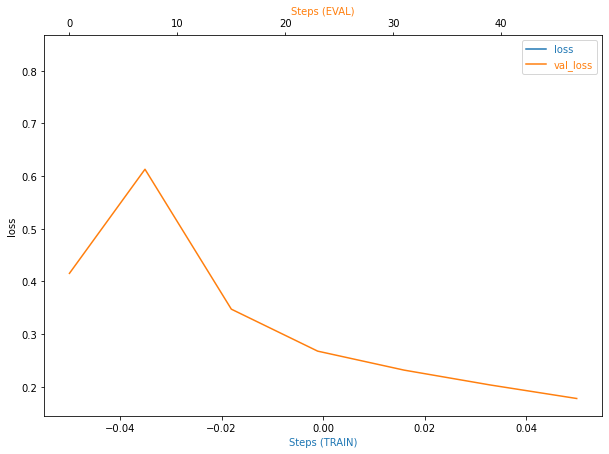

In [37]:
plot_tensor(trial, "loss")

## Debugger and Profiler

In [38]:
# Get system metrics reader from training job
system_metrics_reader = tj.get_systems_metrics_reader()

# Refresh the event file list for the system metrics reader
system_metrics_reader.refresh_event_file_list()

# Create a timeline charts for CPU, GPU and I/O metrics
view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU", "I/O"],
    select_events=["total"],
)


[2023-02-13 17:47:36.030 tensorflow-2-10-cpu-p-ml-t3-medium-1dc977b56e2365772229a702c3e5:23 INFO metrics_reader_base.py:134] Getting 10 event files
select events:['total']
select dimensions:['CPU', 'GPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'I/OWaitPercentage-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


In [39]:
# Create a histogram for CPU, GPU and I/O metrics.
metrics_histogram = MetricsHistogram(system_metrics_reader)
metrics_histogram.plot(
    starttime=0, 
    endtime=system_metrics_reader.get_timestamp_of_latest_available_file(), 
    select_dimensions=["CPU", "GPU", "I/O"], 
    select_events=["total"]                  
)

[2023-02-13 17:47:36.958 tensorflow-2-10-cpu-p-ml-t3-medium-1dc977b56e2365772229a702c3e5:23 INFO metrics_reader_base.py:134] Getting 10 event files
Found 11524 system metrics events from timestamp_in_us:0 to timestamp_in_us:1676310240000000
select events:['total']
select dimensions:['CPU', 'GPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'I/OWaitPercentage-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


filtered_dimensions:{'I/OWaitPercentage-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


In [40]:
# Create a path o save debugger and profiler report
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [41]:
! aws s3 ls {rule_output_path} --recursive

2023-02-13 17:44:59     353716 tensorflow-training-2023-02-13-17-34-30-306/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-13 17:44:59     199157 tensorflow-training-2023-02-13-17-34-30-306/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-13 17:44:55        191 tensorflow-training-2023-02-13-17-34-30-306/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-13 17:44:55        200 tensorflow-training-2023-02-13-17-34-30-306/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-13 17:44:55        126 tensorflow-training-2023-02-13-17-34-30-306/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-13 17:44:55        127 tensorflow-training-2023-02-13-17-34-30-306/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-13 17:44:55        199 tensorflow-training-2023-02-13-17-34-30-306/rule-output/ProfilerReport/profil

In [42]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-890701353618/tensorflow-training-2023-02-13-17-34-30-306/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-890701353618/tensorflow-training-2023-02-13-17-34-30-306/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-890701353618/tensorflow-training-2023-02-13-17-34-30-306/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-890701353618/tensorflow-training-2023-02-13-17-34-30-306/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-890701353618/tensor

In [43]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [44]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
No. There don't seem to be any errors.

If not, suppose there was an error. What would that error look like and how would you have fixed it?
I would fix the issues, considering the suggestions provided by Debugger, and repeat the training job to check model accuracy and optimization.

## Model Deploying

In [45]:
# Deploy model to an endpoint
predictor=estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------!

## Test deployed model

In [46]:
# Set the base directory for the project
base_dir = os.path.join(os.getcwd(), 'is_that_santa', 'test')

# Set the directory for santa images
santa_dir = os.path.join(base_dir, "santa")

# Set the directory for non-santa images
not_a_santa_dir = os.path.join(base_dir, "not-a-santa")

# Get the list of santa images in the santa directory
santa_images = [os.path.join(santa_dir, image) for image in os.listdir(santa_dir)]

# Get the list of non-santa images in the not-a-santa directory
not_a_santa_images = [os.path.join(not_a_santa_dir, image) for image in os.listdir(not_a_santa_dir)]

# Combine the santa images and non-santa images into a single list
images = santa_images + not_a_santa_images

# Shuffle the list of images
random.shuffle(images)

# Get the first ten images from the shuffled list
first_ten_images = images[:10]

# Print the list of first ten images
print(first_ten_images)

['/root/Image-Classification-using-AWS-SageMaker/is_that_santa/test/not-a-santa/41.not-a-santa.jpeg', '/root/Image-Classification-using-AWS-SageMaker/is_that_santa/test/not-a-santa/74.not-a-santa.jpeg', '/root/Image-Classification-using-AWS-SageMaker/is_that_santa/test/not-a-santa/105.not-a-santa.jpeg', '/root/Image-Classification-using-AWS-SageMaker/is_that_santa/test/santa/236.Santa.jpeg', '/root/Image-Classification-using-AWS-SageMaker/is_that_santa/test/santa/492.Santa.jpeg', '/root/Image-Classification-using-AWS-SageMaker/is_that_santa/test/not-a-santa/589.not-a-santa.jpeg', '/root/Image-Classification-using-AWS-SageMaker/is_that_santa/test/santa/609.Santa.jpeg', '/root/Image-Classification-using-AWS-SageMaker/is_that_santa/test/santa/111.Santa.jpeg', '/root/Image-Classification-using-AWS-SageMaker/is_that_santa/test/not-a-santa/316.not-a-santa.jpeg', '/root/Image-Classification-using-AWS-SageMaker/is_that_santa/test/santa/501.Santa.jpeg']


In [47]:
def predict(img_path):
    """
    Predict the classification of an image using the trained model.
    
    Parameters:
        img_path (str): Path to the image to be predicted.
        
    Returns:
        response: The prediction result returned by the predictor.
    """
    # Open image using PIL
    img = Image.open(img_path)
    
    # Reshape the image to 160x160
    img = img.resize((160, 160))
    
    # Convert the image to a numpy array
    img = np.array(img)
    
    # Reshape the numpy array to (1, 160, 160, 3)
    img = img.reshape(1, 160, 160, 3)
    
    response = predictor.predict(img)
    return response

In [96]:
def classifier(predictions):
    """
    This function takes a dictionary of predictions as input and returns either "Is Santa Claus" or "Not Santa Claus".
    
    Parameters:
    predictions (dict): dictionary of predictions, with a key 'predictions' that is a list of lists, where each list
                contains a predicted label and its corresponding confidence score.
                
    Returns:
    str: "Is Santa Claus" if the confidence score of the predicted label is above a certain cutoff, 
         "Not Santa Claus" otherwise.
    
    """
    # Set a threshold for the confidence score
    cutoff = 0.5 

    # Loop through the list of predictions in the input dictionary
    for prediction in predictions['predictions']:
        # Check if the confidence score of the prediction is above the cutoff
        if prediction[0] > cutoff:
            # If it is, return "Is Santa Claus"
            return "Is Santa Claus"
        else:
            # If it isn't, return "Not Santa Claus"
            return "Not Santa Claus"



In [97]:
# Use a list comprehension to get the prediction and image path for each of the first ten images
predictions_and_img_path = [(predict(img), img) for img in first_ten_images]

# Loop through the list of predictions and image paths
for predictions, img_path in predictions_and_img_path:
    # Call the classifier function to get the predicted label
    label = classifier(predictions)
    # Print the predicted label and the image path
    print(f'Prediction: {label}, Actual: {os.path.basename(img_path)}')

Prediction: Not Santa Claus, Actual: 41.not-a-santa.jpeg
Prediction: Not Santa Claus, Actual: 74.not-a-santa.jpeg
Prediction: Not Santa Claus, Actual: 105.not-a-santa.jpeg
Prediction: Is Santa Claus, Actual: 236.Santa.jpeg
Prediction: Not Santa Claus, Actual: 492.Santa.jpeg
Prediction: Not Santa Claus, Actual: 589.not-a-santa.jpeg
Prediction: Is Santa Claus, Actual: 609.Santa.jpeg
Prediction: Is Santa Claus, Actual: 111.Santa.jpeg
Prediction: Not Santa Claus, Actual: 316.not-a-santa.jpeg
Prediction: Is Santa Claus, Actual: 501.Santa.jpeg


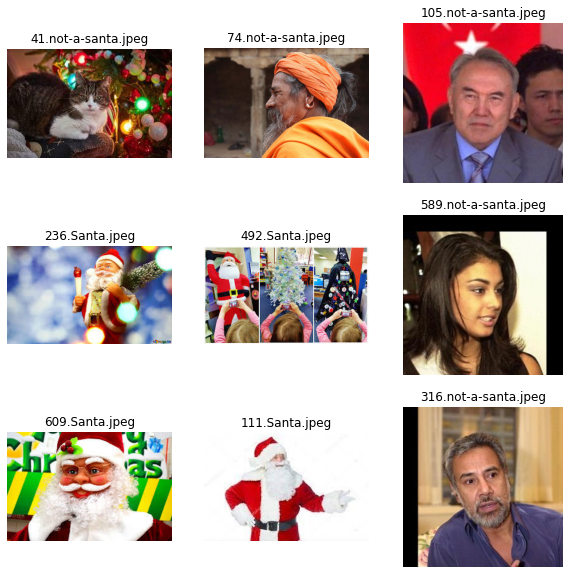

In [92]:
# Show images 
from PIL import Image, ImageFilter

imgs = [item[1] for item in predictions_and_img_path]
plt.figure(figsize=(10, 10))
for i in range(len(imgs) - 1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(Image.open(imgs[i]))
    plt.title(os.path.basename(imgs[i]))
    plt.axis("off")

## Delete endpoint

In [165]:
# Delete endpoint
#predictor.delete_endpoint()